In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/10/02 15:10:20 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/10/02 15:10:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 15:10:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# base_path = "/data/saturation/thesis_run_20240726_single_sims/"
base_path = "/data/saturation/thesis_run_20240929/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 16

configs_df = F.broadcast(
    create_configs_df(
        read_configs(
            base_path,
            spark,
            completed_only=False
        )
    )
).cache()
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark).cache()

24/10/02 15:10:23 WARN CacheManager: Asked to cache already cached data.
24/10/02 15:10:23 WARN HintErrorLogger: A join hint (strategy=broadcast) is specified but it is not part of a join relation.


In [5]:
craters = spark.read.parquet(f"{base_path}/*/craters_*.parquet")
removals = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")

In [6]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [7]:
def plot_metric(
    data: pd.DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    dotted_horizontal_lines: list[float] = None
):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    simulation_ids = data.simulation_id.drop_duplicates()
    for idx, simulation_id in enumerate(simulation_ids):
        data_subset = data[data.simulation_id == simulation_id].sort_values("ntot")
        ax.plot(
            data_subset[x_var],
            data_subset[y_var],
            c=colors[idx % len(colors)],
            ls=line_styles[idx % len(line_styles)]
        )

    if dotted_horizontal_lines:
        for y_val in dotted_horizontal_lines:
            ax.axhline(y_val, color="r", linestyle="--")
    
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    return fig


def plot_metrics(
    *,
    df: pd.DataFrame,
    scenario_name: str,
    ntot_bound_saturation: int,
    show_plots: bool = False
):
    ad_line = df[df.ntot > ntot_bound_saturation].ad.mean()
    print(f"AD line: {ad_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "ad",
        "$A_d$",
        dotted_horizontal_lines=[ad_line]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_ad.png", bbox_inches="tight")
    
    log_mnnd_line = df[df.ntot > ntot_bound_saturation].log_mnnd.mean()
    print(f"log_mnnd line: {log_mnnd_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "log_mnnd",
        "$log_{10}(\\overline{NN}_d)$",
        dotted_horizontal_lines=[log_mnnd_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_mnnd.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "z",
        "$Z$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_z.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "za",
        "$Z_a$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_za.png", bbox_inches="tight")
    
    radius_mean_line = df[df.ntot > ntot_bound_saturation].radius_mean.mean()
    print(f"radius_mean line: {radius_mean_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_mean",
        "$\\overline{r}$",
        dotted_horizontal_lines=[radius_mean_line]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_mean.png", bbox_inches="tight")
    
    radius_stdev_line = df[df.ntot > ntot_bound_saturation].radius_stdev.mean()
    print(f"radius_stdev line: {radius_stdev_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_stdev",
        "$\\sigma_r$",
        dotted_horizontal_lines=[radius_stdev_line]
    )
    if show_plots:
        plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_stdev.png", bbox_inches="tight")


def plot_slope_estimates(estimates_df: pd.DataFrame):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    ax.errorbar(
        estimates_df.ntot,
        estimates_df.alpha,
        estimates_df.sigma,
        ls="None",
        marker="+"
    )
    ax.set_xlabel("$N_{tot}$", fontsize=font_size)
    ax.set_ylabel("$b$", fontsize=font_size)
    ax.set_xscale("log")
    
    return fig

# Comparisons of scenarios

## Shallow slope

In [8]:
scenario_name = "shallow_slope"
selected_slope = -1
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[1])
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
57,0.5,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,135.0,-1.0,250.0,2000.0
66,0.5,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,1.0,-1.0,250.0,2000.0


nobs line: 392.5


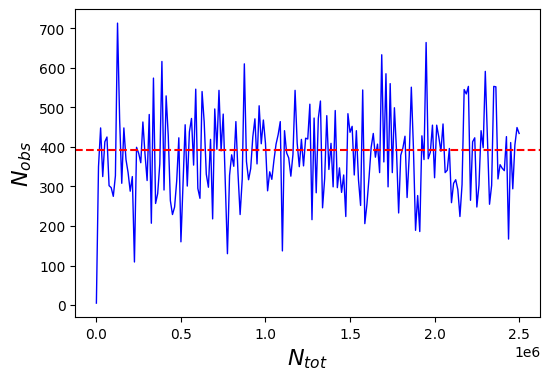

In [9]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

nobs line: 369.0


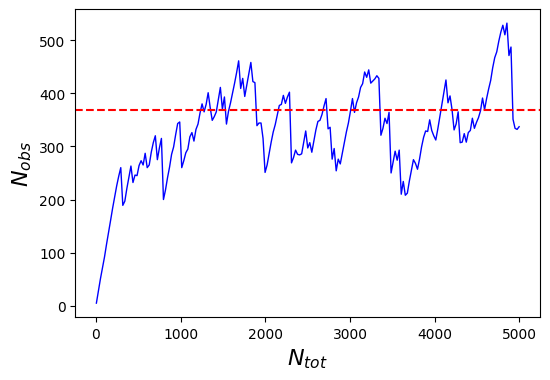

In [10]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

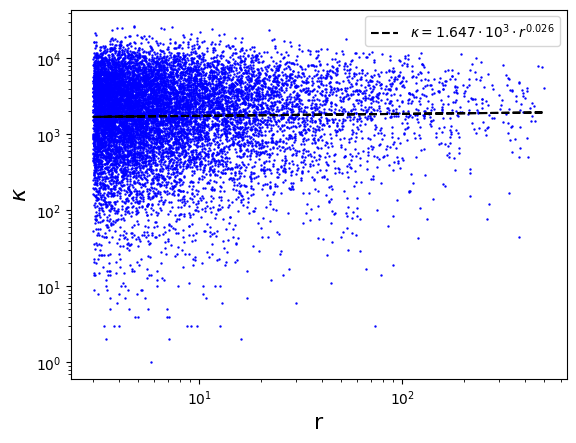

<Figure size 640x480 with 0 Axes>

In [11]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [12]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     916.3
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          3.01e-201
Time:                        14:52:20   Log-Likelihood:            -4.1403e+06
No. Observations:             2502080   AIC:                         8.281e+06
Df Residuals:                 2502078   BIC:                         8.281e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.4070      0.002   3753.490      0.000       7.403       7.411
np.log(radius)     0.0264      0.001     30.271      0.000       0.025       0.028
==============================================================================
Omnibus:                   468217.801   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           969689.471
Skew:                          -1.115   Prob(JB):                         0.00
Kurtosis:                       5.080   Cond. No.                         6.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

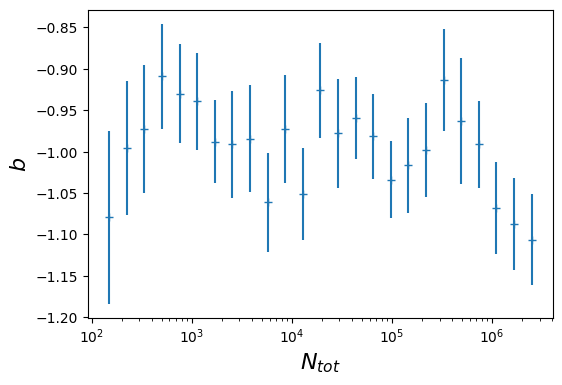

In [13]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

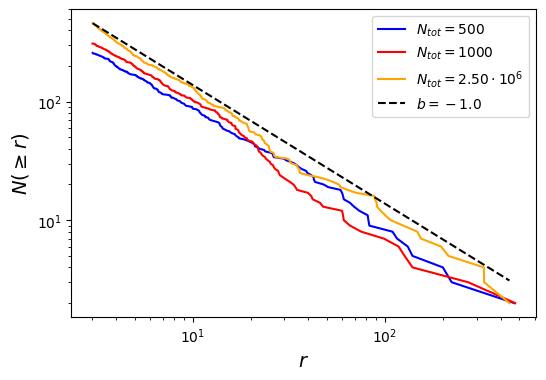

In [14]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 1000, int(2.5*10**6)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Steep slope

In [15]:
scenario_name = "steep_slope"
selected_slope = -4
selected_mrp = 0.5
selected_rmult = 1.5

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
60,0.5,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,2.0,-4.0,250.0,2000.0


nobs line: 1824.5


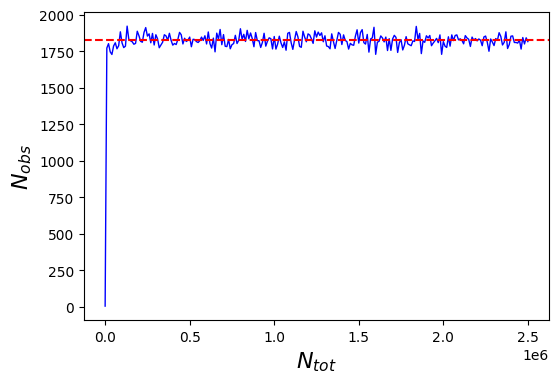

In [16]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

nobs line: 1602.0


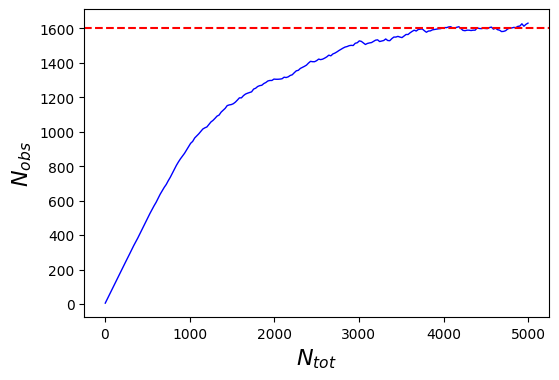

In [17]:
n_samples = 200
df = data.where(
    (F.col("simulation_id") == selected_simulation_id)
    & (F.col("ntot") < 5000)
)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs_beginning.png", bbox_inches="tight")

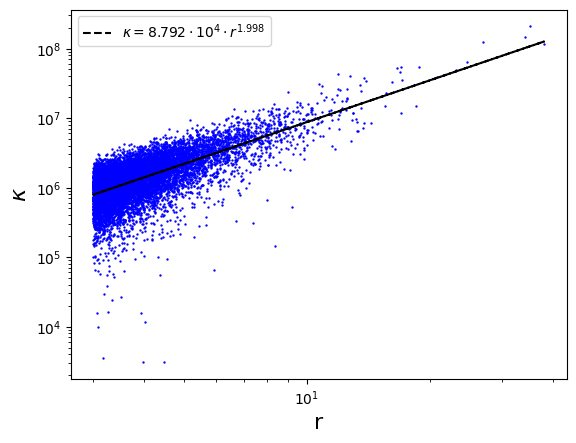

<Figure size 640x480 with 0 Axes>

In [18]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [19]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                 2.109e+06
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:52:45   Log-Likelihood:            -2.0240e+06
No. Observations:             2500737   AIC:                         4.048e+06
Df Residuals:                 2500735   BIC:                         4.048e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.3842      0.002   6033.327      0.000      11.380      11.388
np.log(radius)     1.9984      0.001   1452.298      0.000       1.996       2.001
==============================================================================
Omnibus:                   956707.952   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8531527.971
Skew:                          -1.598   Prob(JB):                         0.00
Kurtosis:                      11.466   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

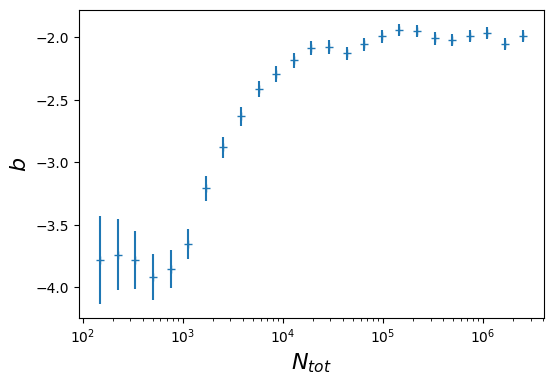

In [20]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

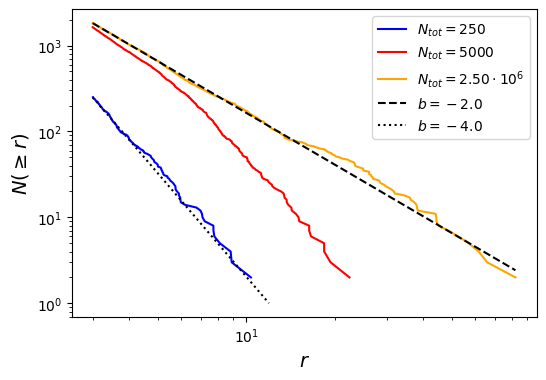

In [21]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[250, 5000, int(2.5*10**6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -4.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## High destruction, b = -2.5

In [22]:
scenario_name = "high_destruction"
selected_slope = -2.5
selected_mrp = 0.75
selected_rmult = 1.9

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
55,0.75,"{'name': 'radius_ratio', 'ratio': '11.0'}",1.9,3.0,-2.5,250.0,2000.0


nobs line: 1314.5


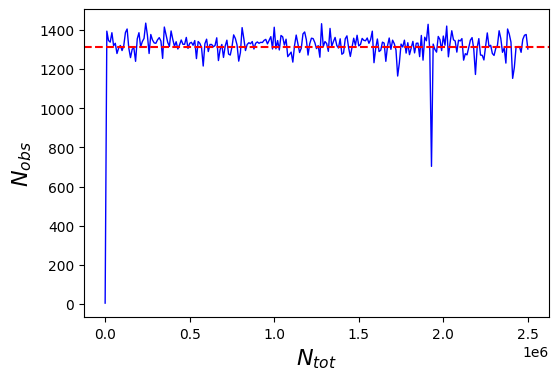

In [23]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue",
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

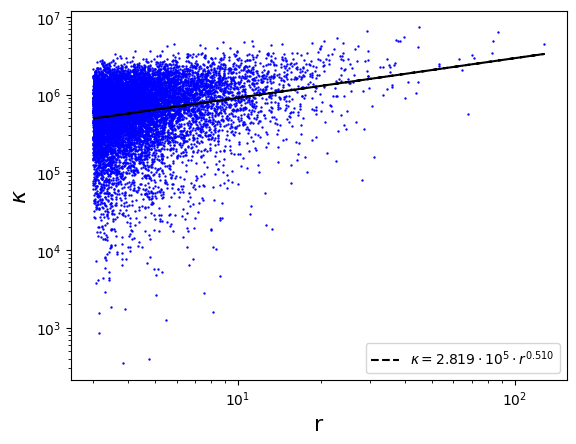

<Figure size 640x480 with 0 Axes>

In [24]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [25]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 1.250e+05
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:53:10   Log-Likelihood:            -3.3154e+06
No. Observations:             2501180   AIC:                         6.631e+06
Df Residuals:                 2501178   BIC:                         6.631e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.5493      0.002   5611.001      0.000      12.545      12.554
np.log(radius)     0.5100      0.001    353.600      0.000       0.507       0.513
==============================================================================
Omnibus:                   921017.545   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4759554.540
Skew:                          -1.713   Prob(JB):                         0.00
Kurtosis:                       8.825   Cond. No.                         8.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

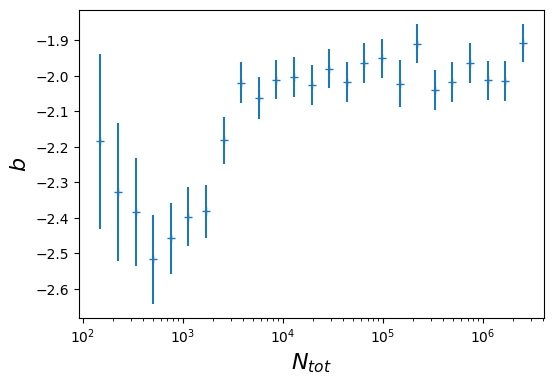

In [26]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

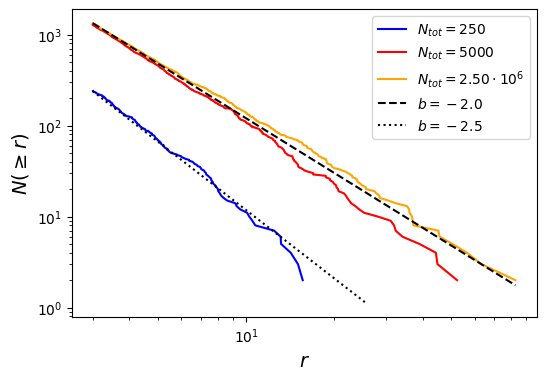

In [27]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[250, 5000, int(2.5*10**6)],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Low destruction, slope = -2.5

Ntot/nobs plot and Z/Za plots restricted in range to show Z/Za reaching significance before "saturation"

In [28]:
scenario_name = "low_destruction"
selected_slope = -2.5
selected_mrp = 0.25
selected_rmult = 1.1

filtered = configs_pdf[(configs_pdf.slope == selected_slope) & (configs_pdf.mrp == selected_mrp) & (configs_pdf.rmult == selected_rmult)]
selected_simulation_id = int(filtered.simulation_id.iloc[0])
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
125,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,4.0,-2.5,250.0,2000.0


nobs line: 24978.0


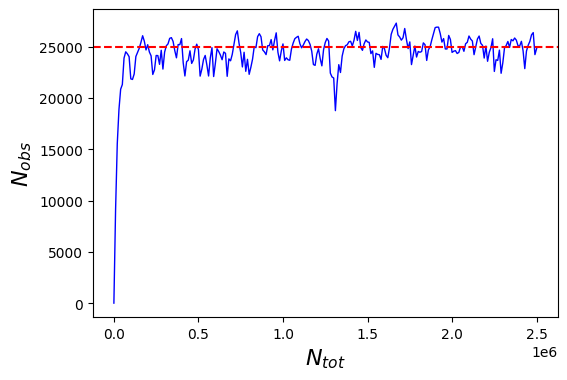

In [29]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

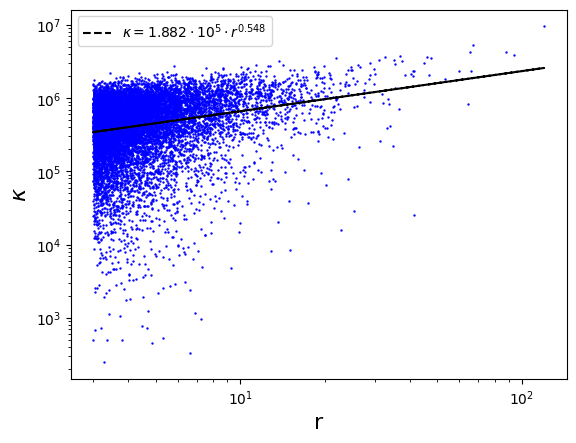

<Figure size 640x480 with 0 Axes>

In [30]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [31]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                 1.252e+05
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:53:34   Log-Likelihood:            -3.4432e+06
No. Observations:             2477696   AIC:                         6.886e+06
Df Residuals:                 2477694   BIC:                         6.886e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.1455      0.002   5061.808      0.000      12.141      12.150
np.log(radius)     0.5480      0.002    353.865      0.000       0.545       0.551
==============================================================================
Omnibus:                   993110.985   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5220386.408
Skew:                          -1.885   Prob(JB):                         0.00
Kurtosis:                       9.030   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

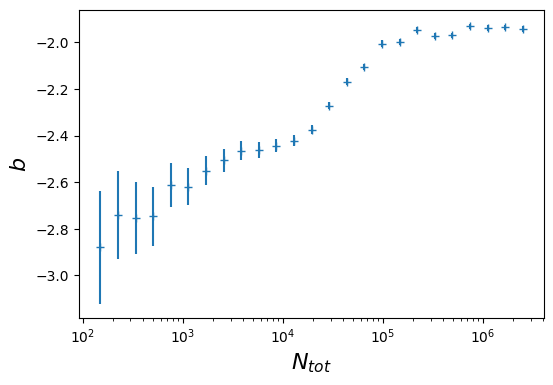

In [32]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

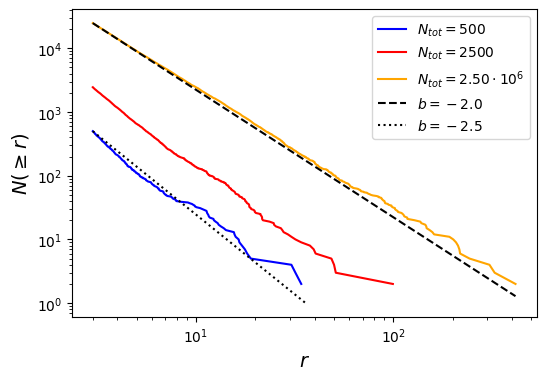

In [33]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 2500, 2500000],
    spark=spark
)

equilibrium_slope = -2.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, shallow slope

In [34]:
scenario_name = "no_erasure_threshold_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 5

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
79,0.5,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,5.0,-1.0,250.0,2000.0


nobs line: 877.0


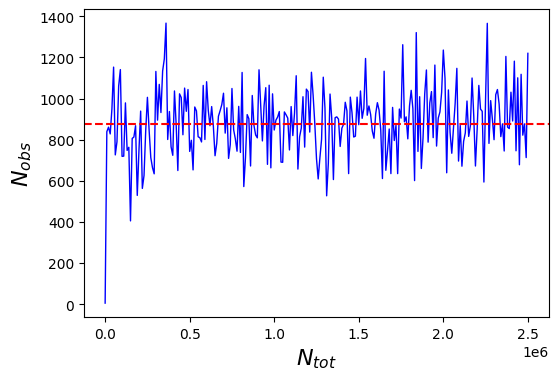

In [35]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

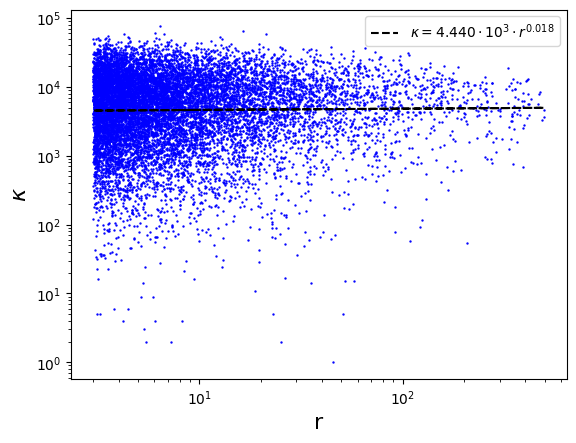

<Figure size 640x480 with 0 Axes>

In [36]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [37]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     428.2
Date:                Wed, 02 Oct 2024   Prob (F-statistic):           4.13e-95
Time:                        14:54:02   Log-Likelihood:            -4.1243e+06
No. Observations:             2501306   AIC:                         8.249e+06
Df Residuals:                 2501304   BIC:                         8.249e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.3985      0.002   4277.919      0.000       8.395       8.402
np.log(radius)     0.0180      0.001     20.692      0.000       0.016       0.020
==============================================================================
Omnibus:                   497157.065   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1106235.168
Skew:                          -1.147   Prob(JB):                         0.00
Kurtosis:                       5.313   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

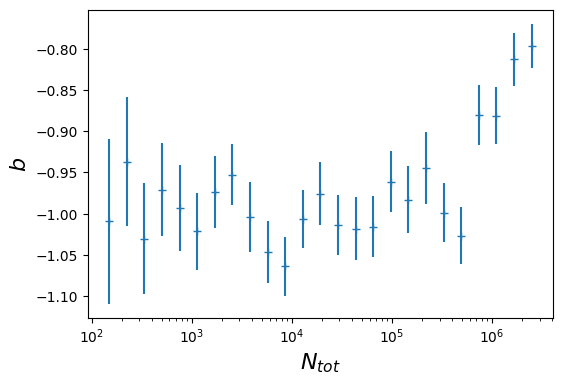

In [38]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

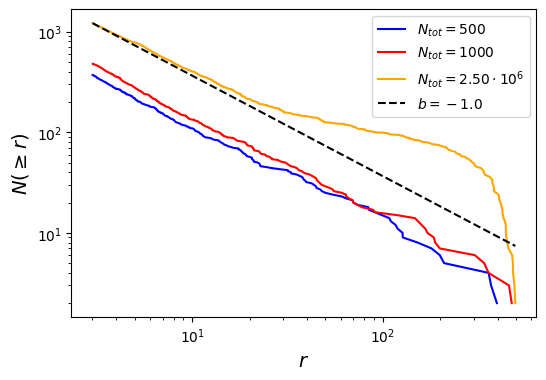

In [39]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 1000, int(2.5*10**6)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## No erasure threshold, steep slope

In [40]:
scenario_name = "no_erasure_threshold_steep_slope"
selected_slope = -4.0
selected_simulation_id = 6

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
56,0.5,"{'name': 'radius_ratio', 'ratio': '1000000.0'}",1.0,6.0,-4.0,250.0,2000.0


nobs line: 1403.5


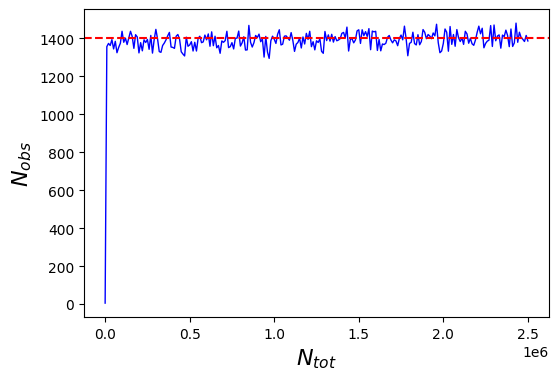

In [41]:
n_samples = 250
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

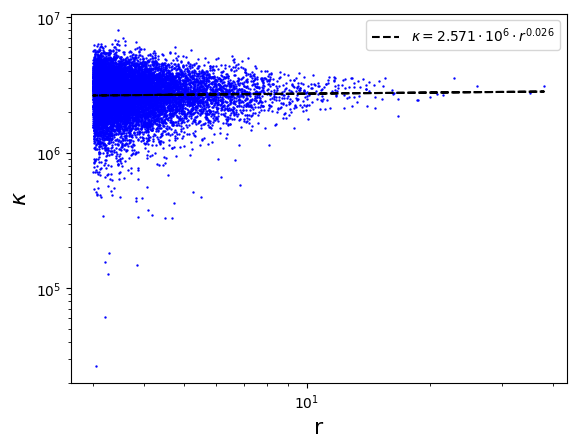

<Figure size 640x480 with 0 Axes>

In [42]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters,
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.005)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [43]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     875.0
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          2.88e-192
Time:                        14:54:26   Log-Likelihood:            -9.1973e+05
No. Observations:             2501142   AIC:                         1.839e+06
Df Residuals:                 2501140   BIC:                         1.839e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.7596      0.001   1.22e+04      0.000      14.757      14.762
np.log(radius)     0.0262      0.001     29.580      0.000       0.024       0.028
==============================================================================
Omnibus:                  1012782.719   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16267868.351
Skew:                          -1.525   Prob(JB):                         0.00
Kurtosis:                      15.116   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

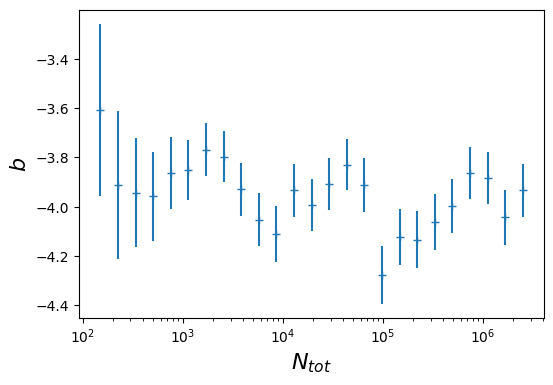

In [44]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=2.5*10**6
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

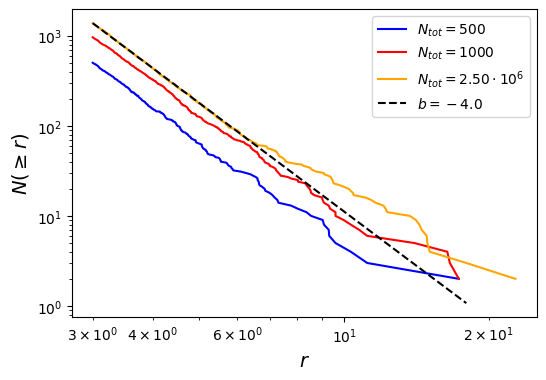

In [45]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 1000, int(2.5*10**6)],
    spark=spark
)

intercept = max(state.shape[0] / state.radius.min()**selected_slope for state in states.values())
slope_intercept_line_styles = [
    (selected_slope, intercept, "--", f"$b = {selected_slope:.1f}$")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

## Investigating lifetime for a range of slopes

In [46]:
scenario_name = "no_erasure_threshold_steep_slope"
selected_simulation_ids = set(range(7, 135))

filtered = configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].sort_values("simulation_id")
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
77,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,7.0,-4.0,250.0,2000.0
76,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,8.0,-4.0,250.0,2000.0
65,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,9.0,-4.0,250.0,2000.0
124,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,10.0,-4.0,250.0,2000.0
84,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,11.0,-3.8,250.0,2000.0
...,...,...,...,...,...,...,...
46,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,130.0,-1.2,250.0,2000.0
137,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,131.0,-1.0,250.0,2000.0
108,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,132.0,-1.0,250.0,2000.0
30,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,133.0,-1.0,250.0,2000.0


In [47]:
sample_fraction = 0.25
craters_sampled = craters.where(F.col("simulation_id").isin(selected_simulation_ids)).sample(sample_fraction).cache()
removals_cached = removals.where(F.col("simulation_id").isin(selected_simulation_ids)).cache()

In [48]:
all_lifetimes = dict()
all_models = dict()

for row in filtered.itertuples():
    lifetimes = get_lifetimes_for_simulation(
        simulation_id=row.simulation_id,
        craters=craters_sampled,
        removals=removals_cached,
        configs_df=configs_df,
        spark=spark
    )
    all_lifetimes[row.simulation_id] = lifetimes

    # Fit the line in log space
    fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
    all_models[row.simulation_id] = fitted_model

In [49]:
df = filtered.copy()
df["fitted_slope"] = [all_models[simulation_id].params.iloc[1] for simulation_id in df.simulation_id]
df["fitted_slope_std_err"] = [all_models[simulation_id].bse.iloc[1] for simulation_id in df.simulation_id]
df

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size,fitted_slope,fitted_slope_std_err
77,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,7.0,-4.0,250.0,2000.0,1.986523,0.004028
76,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,8.0,-4.0,250.0,2000.0,1.989488,0.006972
65,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,9.0,-4.0,250.0,2000.0,2.002728,0.005457
124,0.75,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.9,10.0,-4.0,250.0,2000.0,1.989257,0.008786
84,0.25,"{'name': 'radius_ratio', 'ratio': '3.0'}",1.1,11.0,-3.8,250.0,2000.0,1.785537,0.004111
...,...,...,...,...,...,...,...,...,...
46,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,130.0,-1.2,250.0,2000.0,-0.060320,0.003184
137,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,131.0,-1.0,250.0,2000.0,0.124476,0.002751
108,0.75,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.1,132.0,-1.0,250.0,2000.0,-0.095937,0.002780
30,0.25,"{'name': 'radius_ratio', 'ratio': '7.0'}",1.9,133.0,-1.0,250.0,2000.0,0.094756,0.002766


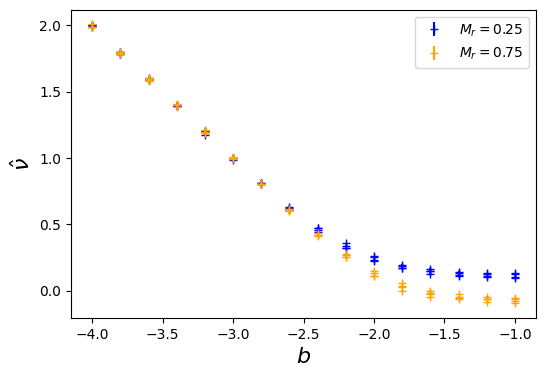

<Figure size 640x480 with 0 Axes>

In [50]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

low_mrp = df[df.mrp == 0.25]
ax.errorbar(
    low_mrp.slope,
    low_mrp.fitted_slope,
    low_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="b",
    label="$M_{r} = 0.25$"
)

high_mrp = df[df.mrp == 0.75]
ax.errorbar(
    high_mrp.slope,
    high_mrp.fitted_slope,
    high_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="orange",
    label="$M_{r} = 0.75$"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\nu}$", fontsize=font_size)
ax.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_nu_by_b_entire_range.png", bbox_inches="tight")

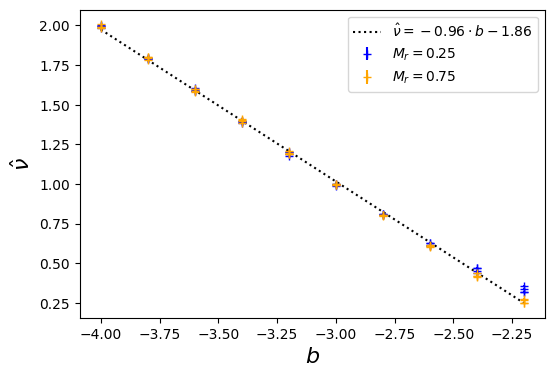

<Figure size 640x480 with 0 Axes>

In [51]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

filtered_df = df[df.slope < -2]
low_mrp = filtered_df[filtered_df.mrp == 0.25]
ax.errorbar(
    low_mrp.slope,
    low_mrp.fitted_slope,
    low_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="b",
    label="$M_{r} = 0.25$"
)

high_mrp = filtered_df[filtered_df.mrp == 0.75]
ax.errorbar(
    high_mrp.slope,
    high_mrp.fitted_slope,
    high_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="orange",
    label="$M_{r} = 0.75$"
)

# Fit the line using OLS
fitted_model = smf.ols(data=filtered_df, formula="fitted_slope ~ 1 + slope").fit()
fitted_intercept = fitted_model.params.iloc[0]
fitted_slope = fitted_model.params.iloc[1]

ax.plot(
    filtered_df.iloc[[0,-1]].slope,
    fitted_model.predict(filtered_df.iloc[[0,-1]].slope),
    c="black",
    ls="dotted",
    label=f"$\\hat{{\\nu}} = {fitted_slope:.2f} \\cdot b - {-fitted_intercept:.2f}$"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\nu}$", fontsize=font_size)
ax.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_nu_by_b_steep.png", bbox_inches="tight")

In [52]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fitted_slope   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.678e+04
Date:                Wed, 02 Oct 2024   Prob (F-statistic):          4.49e-106
Time:                        14:59:12   Log-Likelihood:                 180.56
No. Observations:                  80   AIC:                            -357.1
Df Residuals:                      78   BIC:                            -352.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8557      0.016   -117.912      0.000      -1.887      -1.824
slope         -0.9573      0.005   -191.780      0.000      -0.967      -0.947
==============================================================================
Omnibus:                       41.512   Durbin-Watson:                   1.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.515
Skew:                           1.798   Prob(JB):                     1.22e-23
Kurtosis:                       7.327   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

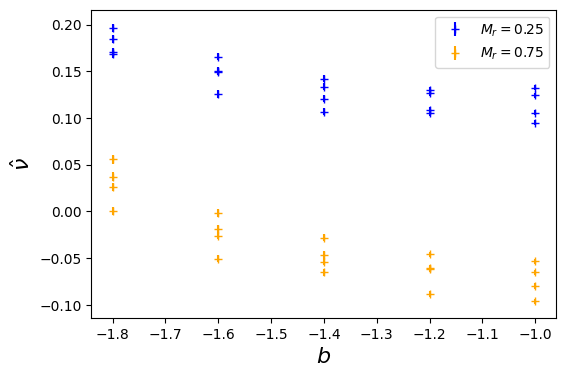

<Figure size 640x480 with 0 Axes>

In [53]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

filtered_df = df[df.slope > -2]
low_mrp = filtered_df[filtered_df.mrp == 0.25]
ax.errorbar(
    low_mrp.slope,
    low_mrp.fitted_slope,
    low_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="b",
    label="$M_{r} = 0.25$"
)

high_mrp = filtered_df[filtered_df.mrp == 0.75]
ax.errorbar(
    high_mrp.slope,
    high_mrp.fitted_slope,
    high_mrp.fitted_slope_std_err,
    ls="None",
    marker="+",
    c="orange",
    label="$M_{r} = 0.75$"
)

ax.set_xlabel("$b$", fontsize=font_size)
ax.set_ylabel("$\\hat{\\nu}$", fontsize=font_size)
ax.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_nu_by_b_shallow.png", bbox_inches="tight")

In [57]:
craters_sampled.uncache()
removals_cached.uncache()

AssertionError: Undefined error message parameter for error class: CANNOT_PARSE_DATATYPE. Parameters: {'error': '[Errno 111] Connection refused'}

## Extended simulation, shallow slope

In [8]:
scenario_name = "long_shallow_slope"
selected_slope = -1.0
selected_simulation_id = 135

filtered = configs_pdf[configs_pdf.simulation_id == selected_simulation_id]
filtered

,mrp,rim_erasure_method,rmult,simulation_id,slope,study_region_padding,study_region_size
57,0.5,"{'name': 'radius_ratio', 'ratio': '5.0'}",1.5,135.0,-1.0,250.0,2000.0


nobs line: 427.5


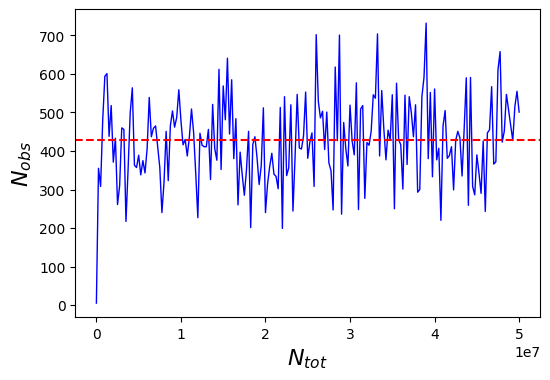

In [9]:
n_samples = 200
df = data.where(F.col("simulation_id") == selected_simulation_id)
df = df.where(F.col("ntot") % (df.count() // n_samples) == 5).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[-(df.shape[0] // 5):].nobs.median()
print(f"nobs line: {nobs_line}")

plt1 = ax1.plot(
    df.ntot,
    df.nobs,
    label="$N_{obs}$",
    lw=1,
    c="blue"
)

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

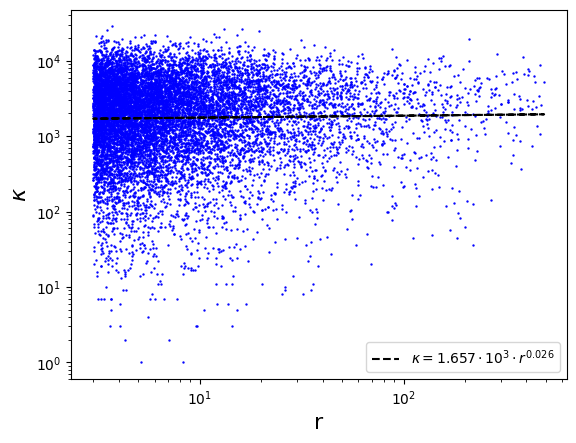

<Figure size 640x480 with 0 Axes>

In [10]:
lifetimes = get_lifetimes_for_simulation(
    simulation_id=selected_simulation_id,
    craters=craters.where(F.col("simulation_id") == selected_simulation_id).sample(0.25),
    removals=removals,
    configs_df=configs_df,
    spark=spark
)

# Sampled scatterplot
sampled = lifetimes.sample(frac=0.001)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    c="blue",
    s=.5,
)

# Fit the line in log space
fitted_model = smf.ols(data=lifetimes, formula="np.log(lifetime) ~ 1 + np.log(radius)").fit()
fitted_intercept = np.exp(fitted_model.params.iloc[0])
fitted_slope = fitted_model.params.iloc[1]

plt.plot(
    sampled.radius,
    np.exp(fitted_model.predict(sampled.radius)),
    ls="dashed",
    c="black",
    label=f"$\\kappa = {get_scientific_notation(fitted_intercept, 3)} \\cdot r^{{ {fitted_slope:.3f} }}$"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("r", fontsize=font_size)
plt.ylabel("$\\kappa$", fontsize=font_size)
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

In [11]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(lifetime)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4563.
Date:                Wed, 02 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:11:59   Log-Likelihood:            -2.0705e+07
No. Observations:            12512303   AIC:                         4.141e+07
Df Residuals:                12512301   BIC:                         4.141e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.4126      0.001   8397.145      0.000       7.411       7.414
np.log(radius)     0.0264      0.000     67.553      0.000       0.026       0.027
==============================================================================
Omnibus:                  2342788.310   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4876228.561
Skew:                          -1.114   Prob(JB):                         0.00
Kurtosis:                       5.096   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

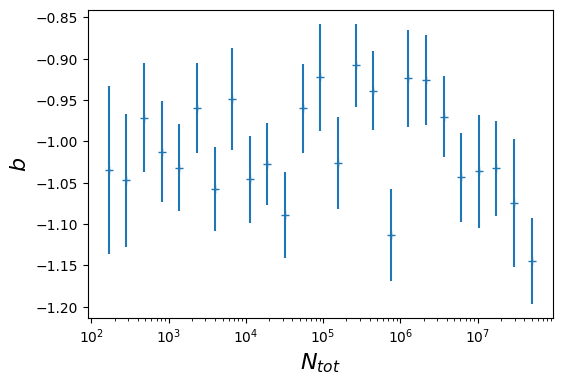

In [12]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    spark=spark,
    max_ntot=50000000
)
slope_estimates = estimate_slopes_for_states(states, configs_dict[selected_simulation_id]["r_stat"])

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

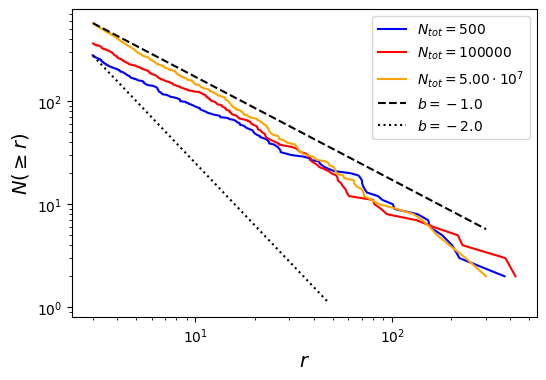

In [13]:
states = get_states_at_ntots(
    simulation_id=selected_simulation_id,
    configs_dict=configs_dict,
    base_path=base_path,
    target_ntots=[500, 100000, int(5e7)],
    spark=spark
)

equilibrium_slope = -1.0
equilibrium_intercept = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.0
production_intercept = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept, "--", f"$b = {equilibrium_slope:.1f}$"),
    (production_slope, production_intercept, "dotted", f"$b = {production_slope:.1f}$"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")